In [84]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Following cell is for concatenating all csv files from the current directory and then saving the dataframe to another csv, to import later

In [17]:
# os.chdir(os.curdir)
# all_files = [i for i in glob.glob('*.csv')]
# data = pd.concat([pd.read_csv(f,delimiter=';') for f in all_files])
# data.head()
# data.to_csv(os.curdir + '\data.csv',index =False, header = True)

In [30]:
data = pd.read_csv('data.csv',parse_dates=['Time'])

In [61]:
#counting the amounts of NaN on every column

data.isnull().sum()

Time                      0
durP1                 44880
ratioP1               44880
P1                    44880
durP2                 44880
ratioP2               44880
P2                    44880
SDS_P1                  609
SDS_P2                  609
PMS_P1                44880
PMS_P2                44880
Temp                   3748
Humidity               3748
BMP_temperature       44880
BMP_pressure          44880
BME280_temperature    44880
BME280_humidity       44880
BME280_pressure       44880
Samples                  23
Min_cycle                23
Max_cycle                23
Signal                   23
HPM_P1                44880
HPM_P2                44880
dtype: int64

In [64]:
#droppping everything over 3748 NaN's

data_cleaned = data.dropna(thresh=3748, axis=1)

In [65]:
data_cleaned.head()

,Time,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal
0,2019-05-03 15:39:46,6.83,5.20,NaN,NaN,1907639.0,74.0,22928.0,-63.0
1,2019-05-03 15:42:13,6.22,5.40,NaN,NaN,1884818.0,76.0,21584.0,-60.0
2,2019-05-03 15:50:01,6.47,5.42,NaN,NaN,1770737.0,79.0,28018.0,-58.0
3,2019-05-03 15:52:28,7.28,5.28,NaN,NaN,1816000.0,77.0,37689.0,-54.0
4,2019-05-03 15:54:55,7.22,5.85,NaN,NaN,1830522.0,78.0,21558.0,-52.0


In [67]:
data_cleaned =data_cleaned.set_index('Time')

In [72]:
data_cleaned.isnull().sum()

SDS_P1        609
SDS_P2        609
Temp         3748
Humidity     3748
Samples        23
Min_cycle      23
Max_cycle      23
Signal         23
dtype: int64

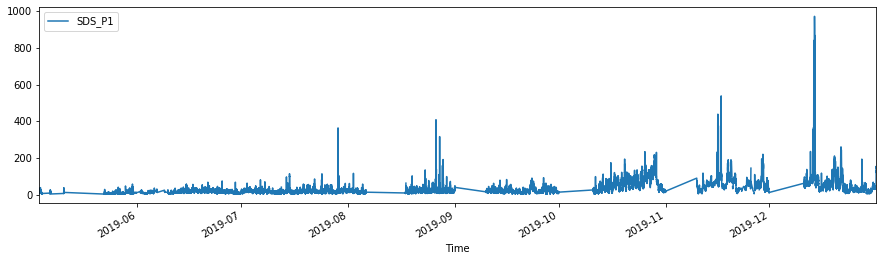

In [86]:
data_cleaned.plot(y='SDS_P1',figsize=(15,4))